In [1]:
# import os
# os.chdir('/Users/evanli/Documents/EvanPys/Progress/')

# from ADlasso2 import AD2_w_utils as ad
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import scipy
import sklearn
import copy
import importlib


In [2]:
import scanpy as sc
import scvelo as scv

data = sc.read('/home/evanlee/PBMC_Hao/Hao_PBMC_level1_rep_cells.h5ad')


In [7]:
label = data.obs['celltype.l1'].tolist()
types = np.unique(label).tolist()
types = [s.replace('_', ' ') for s in types]
types

['B', 'CD4 T', 'CD8 T', 'DC', 'Mono', 'NK', 'other', 'other T']

In [2]:
types = ['B', 'CD4 T', 'CD8 T', 'DC', 'Mono', 'NK', 'other', 'other T']

## Read result_dict from json

In [4]:
!pwd

/home/evanlee/PBMC_Hao/Level_1_alpha0.01/Level1_result


In [8]:
import json

loss_dict = {}
opt_lambda_dict = {}
prevalence_dict = {}
for celltype in types:
    print('Processing: ', celltype)
    # /Users/evanli/Documents/EvanPys/Progress/PBMC_Hao/PBMC_AD2_result/ASDC
    with open(f'./{celltype}/{celltype}_tuning.json') as f:
#     with open(f'./{celltype}_tuning.json') as f:
        result_dict = json.load(f)
    result_dict = {key: np.array(value) for key, value in result_dict.items()}

    # opt_lmbd, fig = ad.lambda_decision(result_dict, k=2)
    # opt_lambda_dict[celltype] = opt_lmbd
    # print('Optimal lambda: {}'.format(opt_lmbd))

    # Read optimal lambda
    with open(f'./{celltype}/{celltype}_opt_lambda.txt', 'r') as f:
#     with open(f'./{celltype}_opt_lambda.txt', 'r') as f:
        opt_lmbd = float(f.read())
    opt_lambda_dict[celltype] = opt_lmbd

    loss_dict[celltype] = result_dict['loss_history']
    prevalence_dict[celltype] = result_dict['Prevalence']

Processing:  B
Processing:  CD4 T
Processing:  CD8 T
Processing:  DC
Processing:  Mono
Processing:  NK
Processing:  other
Processing:  other T


In [9]:
opt_lambda_dict

{'B': 0.0014677992676220707,
 'CD4 T': 0.014677992676220709,
 'CD8 T': 0.0021544346900318864,
 'DC': 0.06812920690579614,
 'Mono': 0.004641588833612781,
 'NK': 0.0021544346900318864,
 'other': 0.046415888336127815,
 'other T': 0.046415888336127815}

In [9]:
# with open('./Pancreas_ADlasso/Pancreas_result/opt_lambda.json', 'w') as f:
#     json.dump(opt_lambda_dict, f)

## Plot summary loss vs. prevalance

In [10]:
log_lmbd_range = np.linspace(np.log(1e-4), np.log(1), 25)
lmbd_range = np.exp(log_lmbd_range)
print(lmbd_range)

[1.00000000e-04 1.46779927e-04 2.15443469e-04 3.16227766e-04
 4.64158883e-04 6.81292069e-04 1.00000000e-03 1.46779927e-03
 2.15443469e-03 3.16227766e-03 4.64158883e-03 6.81292069e-03
 1.00000000e-02 1.46779927e-02 2.15443469e-02 3.16227766e-02
 4.64158883e-02 6.81292069e-02 1.00000000e-01 1.46779927e-01
 2.15443469e-01 3.16227766e-01 4.64158883e-01 6.81292069e-01
 1.00000000e+00]


In [11]:
# create color palette for 8 cell types
import seaborn as sns

keys = list(loss_dict.keys())
palette = sns.color_palette('tab20', n_colors=len(keys))
color_dict = dict(zip(keys, palette))

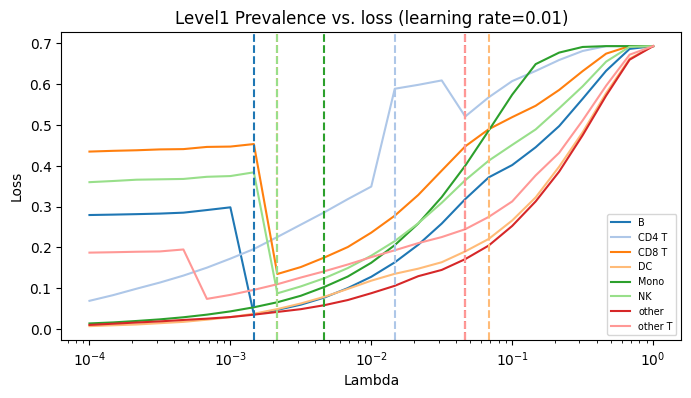

In [13]:
# Plot the loss history against lambda
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 4))

# plot the y-axis values for each key in loss_dict
for key in loss_dict:
    ax.plot(lmbd_range, loss_dict[key], label=key, color=color_dict[key])

# add vertical dotted lines at the values in opt_lambda_dict
for key in opt_lambda_dict:
    ax.axvline(x=opt_lambda_dict[key], linestyle='--', color=color_dict[key])

# set the x-axis label
ax.set_xlabel('Lambda')
ax.set_xscale('log')

# set the y-axis label
ax.set_ylabel('Loss')

# add a legend
ax.legend(loc='lower right', fontsize='x-small')

plt.title('Level1 Prevalence vs. loss (learning rate=0.01)')

# show the plot
plt.show()

## Count feature number

In [3]:
!pwd

/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao/Level_1_alpha0.01/Level1_result


In [19]:
feature_no_df = pd.DataFrame(columns=['Celltype', 'Features', 'Positive features'])
feature_df_dict = {}

In [20]:
i = 0
for celltype in types:
    try:
        feature_df = pd.read_csv(f'./{celltype}/{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        feature_df_dict[celltype] = feature_df
#         feature_df = pd.read_csv(f'./{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
    except:
        print('skipping:', celltype)
        continue
    
    feature_no_df.loc[i] = [celltype, feature_df.shape[0], feature_df[feature_df['Tendency'] == 1].shape[0]]
    print(celltype, 'Feature count:', feature_df.shape[0])
    print(celltype, 'Positive feature count:', feature_df[feature_df['Tendency'] == 1].shape[0])
    print('------------------')
    i += 1

B Feature count: 17
B Positive feature count: 9
------------------
CD4 T Feature count: 1786
CD4 T Positive feature count: 36
------------------
CD8 T Feature count: 26
CD8 T Positive feature count: 9
------------------
DC Feature count: 1
DC Positive feature count: 0
------------------
Mono Feature count: 22
Mono Positive feature count: 14
------------------
NK Feature count: 27
NK Positive feature count: 15
------------------
other Feature count: 1
other Positive feature count: 0
------------------
other T Feature count: 2
other T Positive feature count: 0
------------------


In [21]:
feature_no_df

,Celltype,Features,Positive features
0,B,17,9
1,CD4 T,1786,36
2,CD8 T,26,9
3,DC,1,0
4,Mono,22,14
5,NK,27,15
6,other,1,0
7,other T,2,0


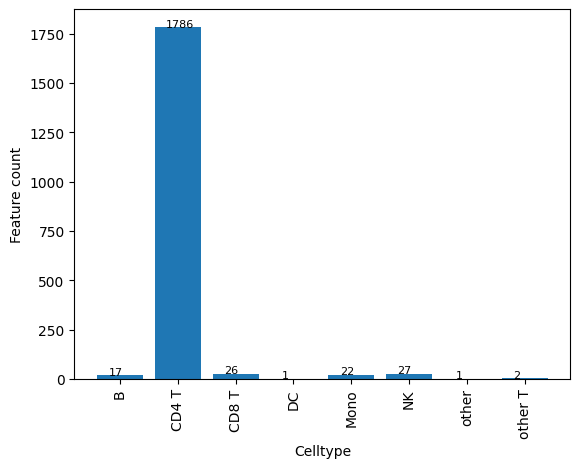

In [22]:
plt.bar(feature_no_df['Celltype'], feature_no_df['Features'])

# Add the values to each bar
for i, v in enumerate(feature_no_df['Features']):
    plt.text(i-0.2, v, str(v), fontsize=8)

# Set the x-axis label
plt.xlabel('Celltype')
plt.xticks(rotation=90)

# Set the y-axis label
plt.ylabel('Feature count')

# Show the plot
plt.show()

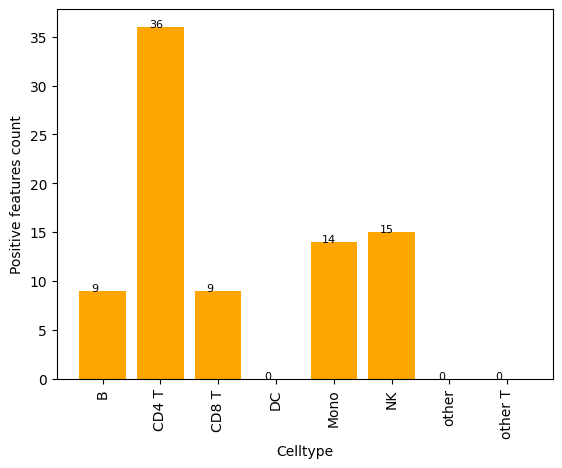

In [23]:
plt.bar(feature_no_df['Celltype'], feature_no_df['Positive features'], color='orange')

# Add the values to each bar
for i, v in enumerate(feature_no_df['Positive features']):
    plt.text(i-0.2, v, str(v), fontsize=8)

# Set the x-axis label
plt.xlabel('Celltype')
plt.xticks(rotation=90)

# Set the y-axis label
plt.ylabel('Positive features count')

# Show the plot
plt.show()

## 各 celltype 的feature 參數絕對值

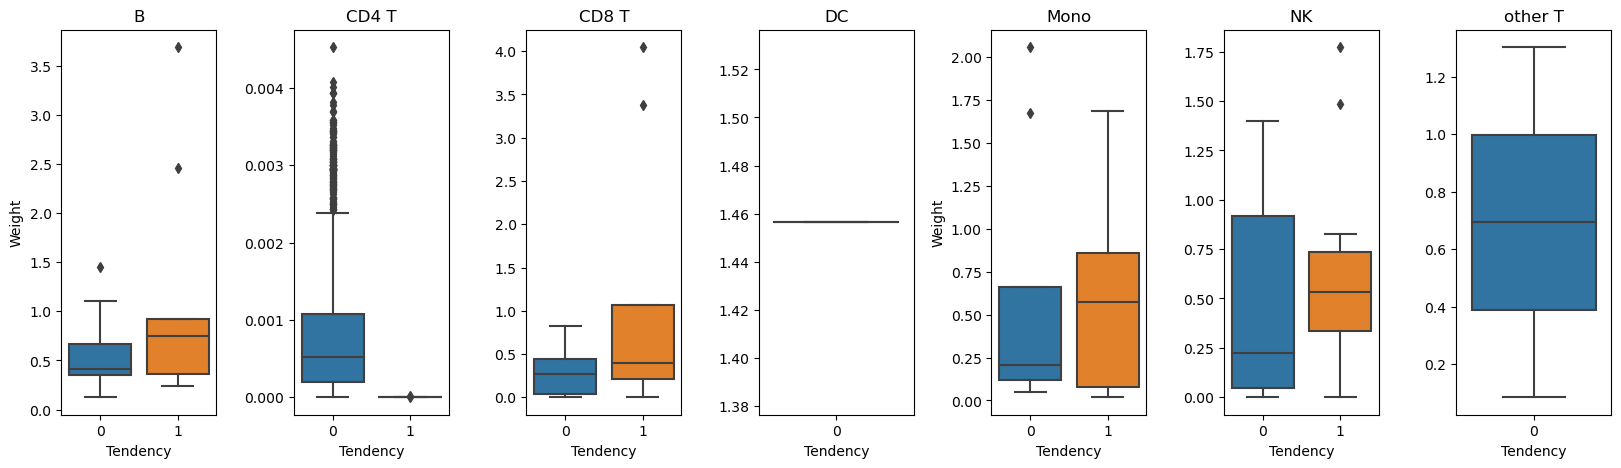

In [42]:
types = ['B', 'CD4 T', 'CD8 T', 'DC', 'Mono', 'NK', 'other T']

fig, axs = plt.subplots(1, len(types), figsize=(20, 5))
fig.subplots_adjust(wspace=0.5)
for i, celltype in enumerate(types):
    feature_df = feature_df_dict[celltype]
    feature_df['Weight'] = feature_df['Weight'].abs()
    if i == 0 or i == 4:
        sns.boxplot(x='Tendency', y='Weight', data=feature_df, ax=axs[i])
    else:
        sns.boxplot(x='Tendency', y='Weight', data=feature_df, ax=axs[i]).set(ylabel=None)
    axs[i].set_title(celltype)